In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import pickle
import numpy as np

from tensorflow.keras import regularizers
import tensorflow as tf
import tensorflow_docs.plots
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from keras_tuner.applications import HyperResNet

from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa


In [2]:
with(open('resources/train_images/dados_2021_08_31_20_12_13.606412_315_imagens','rb')) as openfile:
    dados_brutos = pickle.load(openfile)

In [3]:
with(open('resources/train_images/dados_2021_08_31_20_29_55.928042_298_imagens','rb')) as openfile:
    tuplas_2 = pickle.load(openfile)

In [4]:
for tupla in tuplas_2:
    dados_brutos.append(tupla)

In [5]:
len(dados_brutos)

613

In [6]:
dados_brutos[0][0].shape

(120, 160, 3)

In [7]:
dados_brutos[100][1].replace('LEFT','RIGHT').replace('RIGHT','LEFT')

'LEFT MAX'

## Aumentando os dados com o flip horizontal

Para aumentar a quantidade de dados de treinamento foram utilizadas três estratégias para criação de dados artificiais:

    1. Espelhamento horizontal:
        Todas as imagens foram espelhadas verticalmente e as 'labels' ajustadas de forma a manter a consistência do movimento esperado.
    2. Cortes com ZOOM:
        Novas imagens foram criadas com cortes (ZOOM) que variavam entre 0 - 30% da imagem original, o objetivo é criar imagens com uma pequena diferença espacial das originais.
    3. Suavização de áreas similares:
        O conjunto de dados foi duplicado pela criação de imagens novas que tinham alguns pixels, segmentos entre 16 e 128 pixels, alterados para possuir um valor único.

In [8]:
for idx in range(len(dados_brutos)):
    if 'LEFT' in dados_brutos[idx][1] or 'RIGHT' in dados_brutos[idx][1]:
        flip = cv.flip(dados_brutos[idx][0],1)
        if 'LEFT' in dados_brutos[idx][1]:
            direction = dados_brutos[idx][1].replace('LEFT','RIGHT')
        else:
            direction = dados_brutos[idx][1].replace('RIGHT','LEFT')
        dados_brutos.append((flip,direction))  

In [9]:
len(dados_brutos)

1046

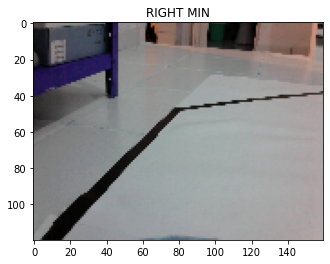

In [10]:
plt.imshow(dados_brutos[900][0])
plt.title(dados_brutos[900][1])
plt.show()

## Aumentando os dados com ZOOM

In [11]:
qnt_img = len(dados_brutos)
for i in range(qnt_img):
    zoom = iaa.Affine(scale=(1,1.3))
    img_zoom = zoom.augment_image(dados_brutos[i][0])
    dados_brutos.append((img_zoom,dados_brutos[i][1]))
len(dados_brutos)

2092

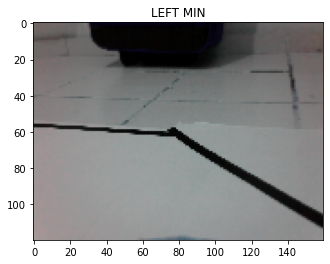

In [12]:
plt.imshow(dados_brutos[1500][0])
plt.title(dados_brutos[1500][1])
plt.show()

## Aumentando os dados com SUPERPIXEL

In [13]:
qnt_img = len(dados_brutos)
for i in range(qnt_img):
    super_pixel = iaa.Superpixels(p_replace=(0.1, 1.0), n_segments=(16, 128))
    img_px = super_pixel.augment_image(dados_brutos[i][0])
    dados_brutos.append((img_px,dados_brutos[i][1]))
len(dados_brutos)

/home/lacouth/anaconda3/envs/cv/lib/python3.9/site-packages/imgaug/augmenters/segmentation.py:271: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = skimage.segmentation.slic(


4184

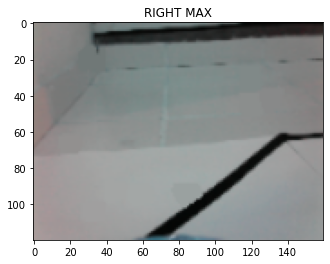

In [14]:
plt.imshow(dados_brutos[2200][0])
plt.title(dados_brutos[2200][1])
plt.show()

## Separando as imagens dos labels e convertendo as imagens para tons de cinza

Para reduzir a dimensionalidade e devido as características da pista utilizada as imagens foram convertidas para tons de cinza, o que diminui a matriz que representa uma imagem de três para uma dimensão. 

Todos os pixels foram normalizados por 255 (valor máximo) para ficarem entre 0 e 1.0.

In [15]:
input_img = [cv.cvtColor(tupla[0],cv.COLOR_RGB2GRAY) for tupla in dados_brutos]

In [16]:
labels = np.array([tupla[1] for tupla in dados_brutos])

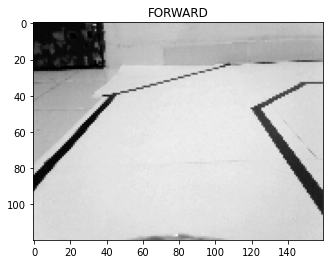

In [17]:
plt.imshow(input_img[0],cmap='gray')
plt.title(labels[0])
plt.show()

## Tratando as labels

In [18]:
label_dict = {'LEFT MIN':0,'LEFT MAX':1,'FORWARD':2, 'RIGHT MIN':3, 'RIGHT MAX':4}
label_encoded = np.array([label_dict[direction] for direction in labels])

## Dividindo os conjuntos de treino e teste

10% dos dados foram separados do conjundo de treinamento para servirem de dados de teste. Esses dados nunca são utilizados durante o treinamento e servem para medir a capacidade de generalização que a rede possui ao final do treinamento.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(input_img, label_encoded, test_size=0.1, random_state=42)

In [20]:
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

In [21]:
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

In [22]:
y_test_hot = tf.one_hot(y_test,5)
y_train_hot = tf.one_hot(y_train,5)

2021-10-15 11:14:16.983760: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Treinando o modelo - 

Devido a limitação de hardware o modelo escolhido foi o clássico MLP (MultiLayer Perceptron) com apenas uma camada escondida. 

O modelo possui:

    1. Uma camada de entrada com 19200 nós. A quantidade de nós é determinada pela quantidade de pixels da imagem (120x160).
    2. Uma camada escondida com 768 nós. A quantidade de nós foi determinada por uma busca automática realizada utilizando o pacote keras-turner que testou valores entre 128 e 1024 nós e obteve melhores resultados com 768 nós.
    3. Uma camada de saída com 5 nós que representam as 5 direções possíveis que o robô pode tomar.
    
    
Durante o treinamento foi utilizada uma técnica chamada 'dropout' (buscar ref) que 'desliga' aleatoriamente, a cada passagem, 10% das ligações entre a camada escondida e a camada de saída , o objetivo final é criar uma rede mais robusta a falhas. O valor de 10% também foi determinado através de uma busca automática com valores entre 0 e 50%.

Os nós escondidos utilizaram como função de ativação não linear uma função sigmoide e os nós de saída uma função exponencial softmax que visa enfatizar a diferença entre as maiores probabilidades de saída.

Para o treinamento da rede foi utilizado o algoritmo ADAM (buscar ref) que é uma variação adaptativa do algoritmo de gradiente descendente, de maneira geral o ADAM utiliza valores adaptativas da taxa de treinamento dentro do gradiente descendente. A taxa de treinamento inicial foi escolhida como sendo $5e-5$ e também foi definida através de uma busca automática com valores entre 5e-5 e 1e-6.

O modelo foi treinado por 844 épocas, a quantidade de épocas máxima foi definida em 1000 épocas mas o treinamento foi configurado para parar caso se passasse mais de 100 épocas sem uma redução no erro de treinamento.

A imagem ao final mostra a evolução

Após o processo de treinamento o modelo obteve um valor de precisão de acerto de 94.5% para as imagens dentro do conjunto de treinamento e 85.4% para as imagens separadas exclusivamente para teste.
    

In [23]:
REG = 0.001
DROP = 0.25
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())


model.add(tf.keras.layers.Dense(768,activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=5e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# hypermodel = HyperResNet(input_shape=(120,160,1), classes=5)

In [25]:
history = model.fit(X_train,y_train_hot,epochs=1000,validation_split=0.2,callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100)])

2021-10-15 11:14:28.477181: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-15 11:14:28.502753: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz


Epoch 1/1000
95/95 [==============================] - 11s 112ms/step - loss: 3.1363 - accuracy: 0.2880 - val_loss: 2.7411 - val_accuracy: 0.3891
Epoch 2/1000
95/95 [==============================] - 10s 105ms/step - loss: 2.6812 - accuracy: 0.4689 - val_loss: 2.4477 - val_accuracy: 0.5910
Epoch 3/1000
95/95 [==============================] - 10s 106ms/step - loss: 2.4829 - accuracy: 0.5583 - val_loss: 2.4666 - val_accuracy: 0.5432
Epoch 4/1000
95/95 [==============================] - 10s 106ms/step - loss: 2.4978 - accuracy: 0.5183 - val_loss: 2.3237 - val_accuracy: 0.5817
Epoch 5/1000
95/95 [==============================] - 10s 106ms/step - loss: 2.3115 - accuracy: 0.5951 - val_loss: 2.2131 - val_accuracy: 0.6175
Epoch 6/1000
95/95 [==============================] - 10s 106ms/step - loss: 2.2293 - accuracy: 0.6161 - val_loss: 2.3007 - val_accuracy: 0.5564
Epoch 7/1000
95/95 [==============================] - 10s 106ms/step - loss: 2.1925 - accuracy: 0.6162 - val_loss: 2.2458 - val_ac

In [ ]:
# history = model.fit(X_train,
#                     y_train_hot, 
#                     validation_split=0.2, 
#                     batch_size = 100, 
#                     epochs=1000,
#                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100),
#                                 tf.keras.callbacks.ModelCheckpoint("SMALL_MLP_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')])

In [26]:
model.evaluate(X_test,y_test_hot,verbose=2)

14/14 - 0s - loss: 0.5299 - accuracy: 0.8544


[0.5298886299133301, 0.8544152975082397]

In [27]:
model.evaluate(X_train,y_train_hot,verbose=2)

118/118 - 2s - loss: 0.3367 - accuracy: 0.9453


[0.3366672098636627, 0.9452854990959167]

In [28]:
model.save('models/model_com_history')

2021-10-15 14:02:06.585073: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model_com_history/assets


In [40]:
with open('model_history','wb') as file:
    pickle.dump(history.history,file)

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

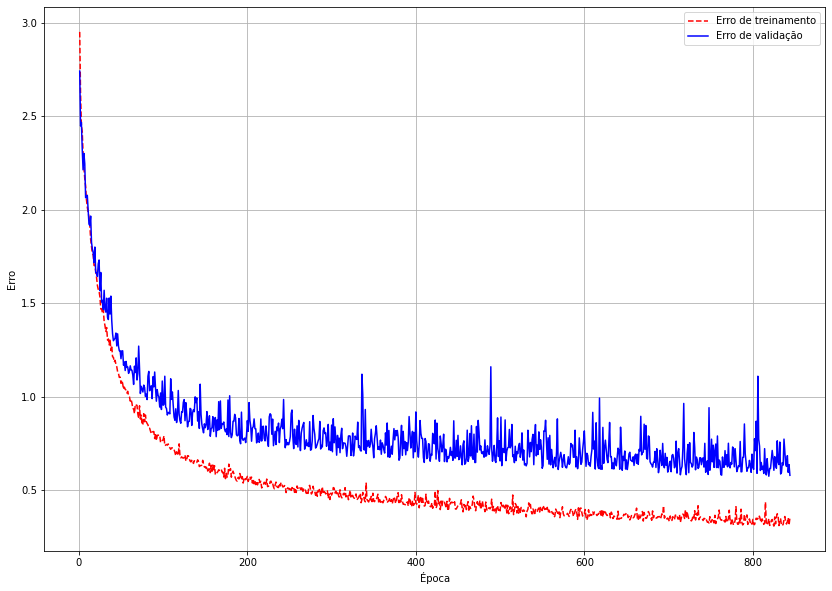

In [38]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)
plt.figure(figsize=(14,10))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Erro de treinamento', 'Erro de validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.grid()
plt.show()

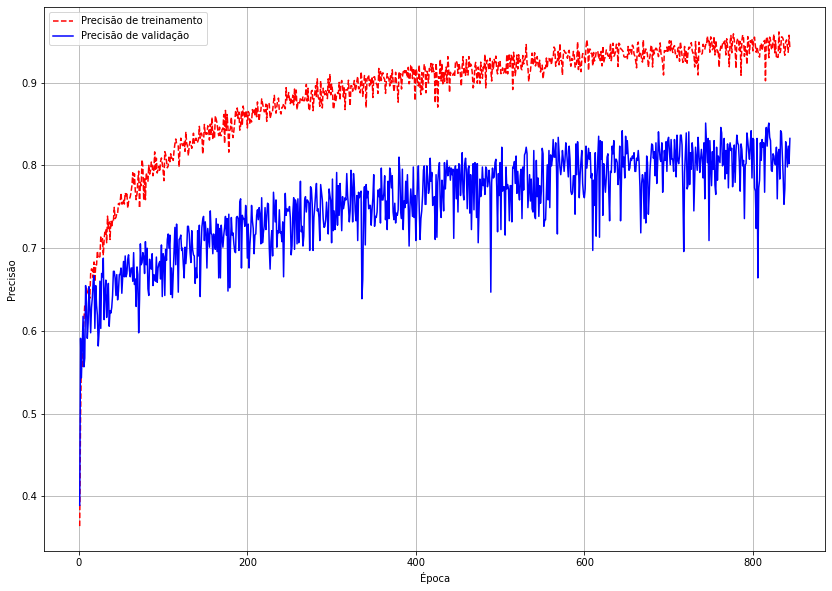

In [39]:
training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_acc) + 1)
plt.figure(figsize=(14,10))
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, val_acc, 'b-')
plt.legend(['Precisão de treinamento', 'Precisão de validação'])
plt.xlabel('Época')
plt.ylabel('Precisão')
plt.grid()
plt.show()